# Setup

In [15]:
import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import matplotlib
import matplotlib.animation as animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

SEASON = 'QS-JAN'
SEASON_TIME = "2023-07"

# Plotting Utils

In [10]:
def plot_stationary_sp(nplots: int = 3, minLon: int = -180, maxLon: int = 180):
    """
    TODO: Add Doc String
    Create a stationary centered on south pole (Longitude: [minLon,maxLon]; Latitude: [-90,-60]
    Returns:
        ax, fig
    """
    # Create subplots
    if nplots == 3:
        figsize = [20, 20]
    if nplots == 2:
        figsize = [10, 10]
    if nplots == 1:
        figsize = [5, 5]

    fig, axs = plt.subplots(nrows=1, ncols=nplots, figsize=figsize, subplot_kw=dict(projection=ccrs.SouthPolarStereo()))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.15)

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if nplots == 1:
        axs =  [axs]

    # Add properties to axes
    for ax in axs:
        # Limit the map to -60 degrees latitude and below.
        ax.set_extent([minLon, maxLon, -90, -50], ccrs.PlateCarree())

        ax.gridlines(draw_labels=True, color="black", linestyle="dashed", zorder=101)
        ax.tick_params(which="both", zorder=103)

        ax.add_feature(cartopy.feature.LAND, facecolor="grey", edgecolor="black", zorder=3)
        ax.add_feature(cartopy.feature.OCEAN, facecolor="white")


        ax.set_boundary(circle, transform=ax.transAxes)

    return fig, axs

def interpolate_seaice_gap(ds):
    """
    There is an issue in the sea ice data at longitude 319.5 and 320.5 (indices 319 and 320).
    This function fills the gap by taking linear interpolation between the two points on 
    either side of the gap (indices 318 and 321).
    """
    ds[:, 319] = ds[:, 318] + (ds[:, 321] - ds[:, 318])/3
    ds[:, 320] = ds[:, 318] + (ds[:, 321] - ds[:, 318])*2/3
    return ds


In [19]:
def spatial_obs_plot(dfs, cmap_info, save_info):
    fig, axes = plot_stationary_sp(nplots=len(dfs.keys()))

    for i, ((key, ds), ax) in enumerate(zip(dfs.items(), axes)):

        if not cmap_info["shared"]:
            levels = cmap_info["levels"][i]
            units = cmap_info["units"][i]
            cmap = cmap_info["cmap"][i]
        else: 
            levels = cmap_info["levels"]
            units = cmap_info["units"]
            cmap = cmap_info["cmap"]

        # Create contour plot
        dsi = interpolate_seaice_gap(ds["ds"].values)
        img = ax.contourf(
            ds["ds"].lon.values,
            ds["ds"].lat.values,
            ds["ds"].values,
            transform=ccrs.PlateCarree(), 
            levels=levels,
            extend="both",
            cmap=cmap,
        )
        
        # Add ice edge
        if key.split("_")[-1] == "siconc":
            if "edge" in ds.keys():
                dsi = interpolate_seaice_gap(ds["edge"].values)
                ax.contour(
                    ds["edge"].lon.values,
                    ds["edge"].lat.values,
                    dsi,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="navy"
                )
            if "edge_clim" in ds.keys():
                dsi = interpolate_seaice_gap(ds["edge_clim"].values)
                ax.contour(
                    ds["edge_clim"].lon.values,
                    ds["edge_clim"].lat.values,
                    ds["edge_clim"].values,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="magenta",
                )
            if "edge_ens" in ds.keys():
                ax.contour(
                    ds["edge_ens"].lon.values,
                    ds["edge_ens"].lat.values,
                    ds["edge_ens"].values,
                    transform=ccrs.PlateCarree(), 
                    levels=[.15],
                    colors="blue",
                )

        # Plot Winds if given
        if "wind" in ds.keys():
            lat_step, lon_step = 5, 5 
            ax.quiver(
                x=ds["wind"][0].lon[::lon_step],
                y=ds["wind"][0].lat[::lat_step],
                u=ds["wind"][0].values[::lat_step, ::lon_step], 
                v=ds["wind"][1].values[::lat_step, ::lon_step], 
                color="black", 
                scale=ds["wind"][2],
                transform=ccrs.PlateCarree(),
            )
        if "include_regions" in ds.keys():
            regional_bounds = {
                "ross": (155, 215, "ROSS"),
                "amundsen": (215, 255, "AM"),
                "bellingshausen": (255, 295, "BS"),
                "weddell": (295, 360, "WE"),
                "south_indian": (0, 75, "SI"),
                "south_west_pacific": (75, 155, "SWP"),
            }

            lat_min, lat_max = -90, -40
            for region, bounds in regional_bounds.items():
                ax.plot(
                    [bounds[0], bounds[0]], 
                    [lat_max, lat_min], 
                    color="black", linewidth=2, linestyle="solid", transform=ccrs.PlateCarree(), zorder=10
                )
                ax.text(
                    (bounds[0]+ bounds[1])/2,
                    -57,
                    bounds[-1],
                    fontsize=12,
                    color="black",
                    fontweight="bold",
                    transform=ccrs.PlateCarree()
                )

        if not cmap_info["shared"]:
            cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.046, pad=0.04)
            cbar.ax.set_title(units)
            if "ticks" in cmap_info.keys():
                cbar.set_ticks(cmap_info["ticks"])
                cbar.set_ticklabels(cmap_info["ticks"])

        # Set properties
        if "title" in ds.keys():
            ax.set_title(ds["title"], loc="right", fontweight="bold", fontsize=12)

        if "left_title" in ds.keys():
            ax.set_title(ds["left_title"], loc="left", fontweight="bold", fontsize=16)

    if len(dfs) == 3: 
        fraction = .016
    elif len(dfs) == 2: 
        fraction = .026

    if cmap_info["shared"]:
        cbar = fig.colorbar(img, ax=axes.ravel().tolist(), orientation="vertical", fraction=fraction, pad=0.04)
        cbar.ax.set_title(cmap_info["units"])
        if "ticks" in cmap_info.keys():
            cbar.set_ticks(cmap_info["ticks"])
            cbar.set_ticklabels(cmap_info["ticks"])

    if save_info["save"]:
        plt.savefig(save_info["path"], dpi=save_info["dpi"], bbox_inches="tight")


# Analysis

## Figure 1 - Character

### Sea ice (a and b)

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/glade/work/zespinosa/conda-en

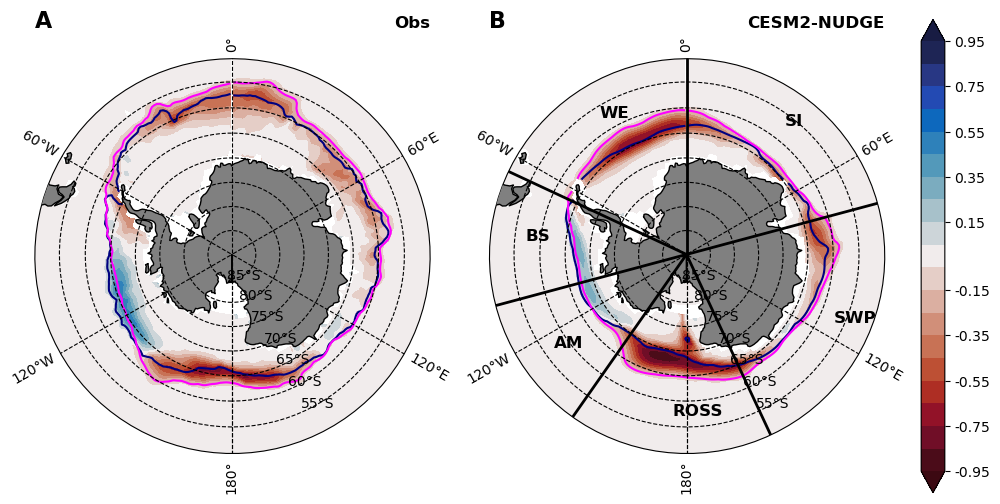

In [20]:
##### BASE CASE WITH NUDGING ####
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")

##### NSIDC Observed Sea Ice #####
nsidc_ice_anoms = xr.open_dataset("../data/nsidc_regrid-anoms.nc")
nsidc_ice = xr.open_dataset("../data/nsidc_regrid.nc")
nsidc_ice_clim = xr.open_dataset("../data/nsidc_regrid-clim.nc")

save_info = {
    "save": False,
    "path": "figures/Figure_1a.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": "",
    "shared": True,
    "levels": np.arange(-.95, 1.05, .1),
    "ticks": [-.95, -.75, -.55, -.35, -.15, .15, .35, .55, .75, .95],
    "tick_labels": [-.95, -.75, -.55, -.35, -.15, .15, .35, .55, .75, .95],
}

nsidc_siconc = {
    "title": "Obs",
    "ds": nsidc_ice_anoms["cdr_seaice_conc"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": nsidc_ice["cdr_seaice_conc"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": nsidc_ice_clim["cdr_seaice_conc"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    "left_title": "A"
}

cesm2_siconc = {
    "title": "CESM2-NUDGE",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    "left_title": "B", 
    "include_regions": True,

}

spatial_obs_plot(
    dfs={
        "nsidc_siconc":  nsidc_siconc, 
        "cesm2_siconc": cesm2_siconc,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### sst (c and d)

In [ ]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_1cd.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-2.75, 3.25, .5),
    "shared": True,
    "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

era5 = {
    "ds": era5_atm_anoms["sst"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "C"
}
cesm2 = {
    "ds": cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "D"
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### mslp and winds

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_1ef.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "",
    "left_title": "E",
    "ds": era5_atm_anoms["msl"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "",
    "left_title": "F",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Figure 2 - ENSO

### siconc

In [ ]:
enso_cesm2_atm_anoms = xr.open_dataset("../data/enso_cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
# enso_cesm2_ice = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12.nc")

cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")


save_info = {
    "save": True,
    "path": "figures/Figure_2abc.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": r"SICONC",
    "levels": np.arange(-.3, 0.35, .05),
    "shared": True
}

enso = {
    "title": "ENSO",
    "left_title": "A",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
}

no_enso = {
    "title": "NO ENSO",
    "left_title": "B",
    "ds": enso_cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    # "edge": enso_cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
}

res = {
    "title": "Residual",
    "left_title": "C",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
}

spatial_obs_plot(
    dfs={
        "enso_siconc": enso, 
        "noenso_siconc": no_enso,
        "res": res,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_2ab.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": r"SICONC",
    "levels": np.arange(-.95, 1.05, .1),
    "shared": True
}

enso = {
    "title": "ENSO",
    "left_title": "A",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
}

no_enso = {
    "title": "NO ENSO",
    "left_title": "B",
    "ds": enso_cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    # "edge": enso_cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
}

spatial_obs_plot(
    dfs={
        "enso_siconc": enso, 
        "noenso_siconc": no_enso,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_2a_res.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r],
    "units":[r"SICONC"],
    "levels": [np.arange(-.25, 0.26, .01)],
    "shared": False
}

res = {
    "title": "ENSO - NO_ENSO",
    "left_title": "A",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
}

spatial_obs_plot(
    dfs={
        "res": res,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### sst

In [ ]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_sst_anoms = xr.open_dataset("../data/enso_cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_2def.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-1., 1.1, .1),
    "shared": True,
    # "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    # "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

enso = {
    "ds": cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "D",
    "title": "ENSO"
}
no_enso = {
    "ds": enso_cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "E",
    "title": "NO ENSO"
}
res = {
    "ds": cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "F",
    "title": "Residual"
}

spatial_obs_plot(
    dfs={
        "enso": enso, 
        "no_enso": no_enso,
        "res": res,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_2de.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-2.5, 2.75, .25),
    "shared": True,
    # "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    # "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

enso = {
    "ds": cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "C",
    "title": "ENSO"
}
no_enso = {
    "ds": enso_cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "D",
    "title": "NO ENSO"
}

spatial_obs_plot(
    dfs={
        "enso": enso, 
        "no_enso": no_enso,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_2b_res.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": [cmocean.cm.balance],
    "units": [r"SST [K]"],
    "levels": [np.arange(-.75, .80, .05)],
    "shared": False,
    # "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    # "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

res = {
    "ds": cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "B",
    "title": "ENSO - NO_ENSO"
}

spatial_obs_plot(
    dfs={
        "res": res,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### mslp

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_atm_anoms = xr.open_dataset("../data/enso_cesm2_atm_monthly_1950-01_2023-12-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_2ghi.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

enso = {
    "title": "ENSO",
    "left_title": "G",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

no_enso = {
    "title": "NO ENSO",
    "left_title": "H",
    "ds": enso_cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        enso_cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        enso_cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

res = {
    "title": "Residual",
    "left_title": "I",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100 - enso_cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        30,
    ]
}

spatial_obs_plot(
    dfs={
        "enso": enso, 
        "no_enso": no_enso,
        "res": res,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_2ef.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

enso = {
    "title": "ENSO",
    "left_title": "E",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

no_enso = {
    "title": "NO ENSO",
    "left_title": "F",
    "ds": enso_cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        enso_cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        enso_cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "enso": enso, 
        "no_enso": no_enso,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_2c_res.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": [cmocean.cm.balance],
    "units": [r"MSLP [hPa]"],
    "levels": [np.arange(-6, 6.5, .5)],
    "shared": False
}

res = {
    "title": "ENSO - NO_ENSO",
    "left_title": "C",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100 - enso_cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        30,
    ]
}

spatial_obs_plot(
    dfs={
        "res": res,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Figure 3 - Thermo and Dynamics

In [ ]:
enso_cesm2_atm_anoms = xr.open_dataset("../data/enso_cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
# enso_cesm2_ice = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12.nc")

cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_3abc.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"$\frac{dA}{dt}$ [%]",
    "shared": True,
    "levels": np.arange(-1, 1.1, .1)
}

cesm2_thermo = {
    "title": r"$\frac{dA}{dt}_{thermo}$",
    "left_title": "A",
    "ds": cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}

cesm2_dynam = {
    "title": r"$\frac{dA}{dt}_{dynam}$",
    "left_title": "B",
    "ds": cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

cesm2_sum= {
    "title": r"$\frac{dA}{dt}$",
    "left_title": "C",
    "ds": cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() + cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
        "cesm2_sum": cesm2_sum,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
enso_cesm2_atm_anoms = xr.open_dataset("../data/enso_cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
# enso_cesm2_ice = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12.nc")

cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_SdV.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"",
    "shared": True,
    "levels": np.arange(-1, 1.1, .1)
}

cesm2_thermo = {
    "title": r"$(\frac{dV}{dt})_{thermo}$",
    "left_title": "A",
    "ds": cesm2_ice_anoms["dvidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}

cesm2_dynam = {
    "title": r"$(\frac{dV}{dt})_{dynam}$",
    "left_title": "B",
    "ds": cesm2_ice_anoms["dvidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

cesm2_sum= {
    "title": r"$(\frac{dV}{dt})_{sum}$",
    "left_title": "C",
    "ds": cesm2_ice_anoms["dvidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() + cesm2_ice_anoms["dvidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
        "cesm2_sum": cesm2_sum,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
# import matplotlib as mpl
# from matplotlib import rc
# mpl.rcParams.update(mpl.rcParamsDefault)
# rc('text', usetex=True)
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

save_info = {
    "save": True,
    "path": "figures/Figure_3a.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": ["PuOr"],
    "units": [r""],
    "levels": [np.arange(-1, 1.1, .1)],
    "shared": False,
}

cesm2_thermo = {
    "title": r'$(\frac{dA}{dt})_{thermo}$',
    "left_title": "E",
    "ds": cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}

spatial_obs_plot(
    dfs={
        "cesm2_thermo":  cesm2_thermo, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_3b.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": ["PuOr"],
    "units": [r""],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1)]
}

cesm2_dynam = {
    "title": r"$(\frac{dA}{dt})_{dynam}$",
    "left_title": "F",
    "ds": cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_dynam": cesm2_dynam,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
import xcdat as xc
from global_land_mask import globe

### Load JJA 2023 ###
# dA/dt
da_thermo = cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
da_dynamic = cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
# dV/dt
dv_thermo = cesm2_ice_anoms["dvidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()
dv_dynamic = cesm2_ice_anoms["dvidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()

def calc_avg(ds):
    """
    Calculate spatially weighted average using xcdat
    """
    ds = ds.sel(lat=slice(-85, -60)).rename("var").to_dataset()
    # Plot between -1 and 1
    # ds["var"].plot(vmin=-1, vmax=1)
    ds = ds.drop("time")
    ds = ds.bounds.add_bounds("X")
    ds = ds.bounds.add_bounds("Y")
    return ds.spatial.average("var")["var"].values

def get_land_sea_mask(ds):
    """
    Creates a land_sea_mask using global_land_mask and ds
    """
    # Swap lon from 0-360 to -180-180 using xarray
    ds = xc.swap_lon_axis(ds, to=(-180., 180.))
    # Make a grid
    lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
    land_mask = globe.is_land(lat_grid, lon_grid)
    # Create xarray using land_mask
    land_mask = xr.DataArray(land_mask, coords=[ds.lat, ds.lon], dims=["lat", "lon"])
    land_mask = land_mask.rename("land_mask").to_dataset()
    # Add bounds
    land_mask = land_mask.bounds.add_bounds("X")
    land_mask = land_mask.bounds.add_bounds("Y")
    land_mask = xc.swap_lon_axis(land_mask, to=(0, 360))

    return land_mask

def apply_land_mask(ds, land_mask):
    # Set land to nan
    ds = ds.where(land_mask["land_mask"] == 0)

    return ds

lsm = get_land_sea_mask(cesm2_ice_anoms)

da_dynamic = calc_avg(apply_land_mask(da_dynamic, lsm))
da_thermo = calc_avg(apply_land_mask(da_thermo, lsm))
dv_dynamic = calc_avg(apply_land_mask(dv_dynamic, lsm))
dv_thermo = calc_avg(apply_land_mask(dv_thermo, lsm))

print("Area Dynamic Tendency: ", da_dynamic)
print("Area Thermo Tendency: ", da_thermo)
print("Area Total Tendency: ", da_dynamic + da_thermo)

print("Volume Dynamic Tendency: ", dv_dynamic)
print("Volume Thermo Tendency: ", dv_thermo)
print("Volume Total Tendency: ", dv_dynamic + dv_thermo)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_3c.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": ["PuOr"],
    "units": [r""],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1)]
}

cesm2_sum= {
    "title": r"$(\frac{dA}{dt})_{sum}$",
    "left_title": "G",
    "ds": cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() + cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_sum": cesm2_sum,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")

save_info = {
    "save": False,
    "path": "figures/Figure_3def.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"$\frac{dA}{dt}$ [%]",
    "shared": True,
    "levels": np.arange(-1, 1.1, .1)
}

cesm2_thermo = {
    "title": r"$\frac{dA}{dt}_{thermo}$ (2023-JJA)",
    "left_title": "D",
    "ds": enso_cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}

cesm2_dynam = {
    "title": r"$\frac{dA}{dt}_{dynam}$ (2023-JJA)",
    "left_title": "E",
    "ds": enso_cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        enso_cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        enso_cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

cesm2_sum= {
    "title": r"$\frac{dA}{dt}$ (2023-JJA)",
    "left_title": "F",
    "ds": enso_cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() + enso_cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        enso_cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        enso_cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .75
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
        "cesm2_sum": cesm2_sum,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_3ghi.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"$\frac{dA}{dt}$ [%]",
    "shared": True,
    "levels": np.arange(-.5, .55, .05)
}

cesm2_thermo = {
    "title": r"$\frac{dA}{dt}_{thermo}$",
    "left_title": "D",
    "ds": cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}

cesm2_dynam = {
    "title": r"$\frac{dA}{dt}_{dynam}$",
    "left_title": "E",
    "ds": cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .5
    ]
}

cesm2_sum= {
    "title": r"$\frac{dA}{dt}$",
    "left_title": "F",
    "left_title": "F",
    "ds": (cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() + cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()) -  
     (enso_cesm2_ice_anoms["daidtd"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() + enso_cesm2_ice_anoms["daidtt"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["uvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["vvel"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        .5
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
        "cesm2_sum": cesm2_sum,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Figure 4 - Forecast Analysis

In [ ]:
ENSEMBLE_MEMBERS = ["1980", "1985", "1989", "1990", "1993", "1994", "1998", "1999", "2000", "2003", "2004", "2005", "2006", "2007", "2009", "2012", "2013", "2014", "2018", "2020", "2021"]

def load_ensemble(file_name, ens_mems, drop_vars=[]):
    """
    Load the processed data files for each ensemble member and return a concatenated dataset.
    """
    ens = []
    for mem in ens_mems: 
        try:
            cesm2_ens = xr.open_dataset(
                f"../data/persistence_ensemble/{mem}/{mem}{file_name}",
                chunks="auto", 
                drop_variables=drop_vars
            )
            ens.append(cesm2_ens)
        except Exception as e:
            print(f"Could not load {mem}")

    ens = xr.concat(ens, "year")

    return ens

### Figure 4a sea ice concentration

In [ ]:
##### BASE CASE WITH NUDGING ####
cesm2_ice_ens_anoms = load_ensemble(file_name=f"_cesm2_ice_monthly_1950-01_2023-12-anoms.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")
cesm2_ice_ens = load_ensemble(file_name=f"_cesm2_ice_monthly_1950-01_2023-12-regrid.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")

cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_4a.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": "",
    "shared": True,
    "levels": np.arange(-.95, 1.05, .1),
    "ticks": [-.95, -.75, -.55, -.35, -.15, .15, .35, .55, .75, .95],
    "tick_labels": [-.95, -.75, -.55, -.35, -.15, .15, .35, .55, .75, .95],
}

cesm2_siconc = {
    "title": "CESM2-NUDGE",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    "left_title": "A"
}

cesm2_forecast_siconc = {
    "title": "CESM2-NUDGE Forecast",
    "ds": cesm2_ice_ens_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice_ens["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Navy (2023 JJA)
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    "left_title": "B"
}


spatial_obs_plot(
    dfs={
        "cesm2_siconc": cesm2_siconc,
        "cesm2_forecast_siconc": cesm2_forecast_siconc,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Figure 4cd - SSTs

In [ ]:
cesm2_sst_ens_anoms = load_ensemble(file_name=f"_cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_4c.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-2.75, 3.25, .5),
    "shared": True,
    "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

cesm2 = {
    "ds": cesm2_sst_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "C",
    "title": "CESM2-NUDGE",
}

cesm2_ens = {
    "ds": cesm2_sst_ens_anoms["SST"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "left_title": "D",
    "title": "CESM2-NUDGE Forecast",
}

spatial_obs_plot(
    dfs={
        "cesm2": cesm2,
        "cesm2_ens": cesm2_ens, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Figure 4ef - ATM

In [ ]:
cesm2_atm_ens_anoms = load_ensemble(file_name=f"_cesm2_atm_monthly_1950-01_2023-12-anoms.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")
cesm2_atm_ens = load_ensemble(file_name=f"_cesm2_atm_monthly_1950-01_2023-12-regrid.nc", ens_mems=ENSEMBLE_MEMBERS).mean("year")

cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")

In [ ]:
save_info = {
    "save": True,
    "path": "figures/Figure_4ef.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

cesm2 = {
    "title": "CESM2-NUDGE",
    "left_title": "E",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

cesm2_ens = {
    "title": "CESM2-NUDGE Forecast",
    "left_title": "F",
    "ds": cesm2_atm_ens_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_ens_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_ens_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2": cesm2,
        "cesm2_ens": cesm2_ens,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Figure SX - MXL

In [ ]:
cesm2_mxl_anoms = xr.open_dataset("../data/cesm2_ocn-mxl_monthly_1950-01_2023-12-regrid.nc")

# save_info = {
#     "save": False,
#     "path": "figures/Figure_SX_HMXL.png",
#     "dpi": 400,
# }

# cmap_info = {
#     "cmap": [cmocean.cm.balance],
#     "units": [r"HMXL [m]"],
#     "levels": [np.arange(-200, 220, 20)],
#     "shared": False,
# }

# mxl = {
#     "ds": cesm2_mxl_anoms["HMXL"].resample(time="QS-DEC").mean(dim="time", skipna=True).sel(time="2023-06").squeeze(),
#     "left_title": "A",
#     "title": "Mixed-Layer-Depth"
# }

# spatial_obs_plot(
#     dfs={
#         "mxl": mxl,
#     }, 
#     cmap_info=cmap_info, 
#     save_info=save_info, 
# )

a = cesm2_mxl_anoms["HMXL"].resample(time=SEASON).mean(dim="time", skipna=True).sel(time=SEASON_TIME).squeeze()
np.nanmax(a.values)

## Figure SX - Jan - August SLP and Winds

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_SX-ab-SLP.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "ERA5: JJA-2023",
    "left_title": "A",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2-NUDGE: JJA-2023",
    "left_title": "B",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_SX-cd-SLP.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "ERA5: MAM-2023",
    "left_title": "C",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2-NUDGE: MAM-2023",
    "left_title": "D",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_SX-ef-SLP.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "ERA5: DJF-2023",
    "left_title": "E",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2-NUDGE: DJF-2023",
    "left_title": "F",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(), # Meridional
        75,
    ]
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    },
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Figure SX: 2023-12 SST Conditions

<xarray.DataArray 'sst' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    time     datetime64[ns] 2023-10-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    units:          K
    long_name:      Sea surface temperature
    regrid_method:  bilinear
    operation:      temporal_avg
    mode:           departures
    freq:           month
    weighted:       True
<xarray.DataArray 'time' (time: 538)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', ..., '2023-08-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-10-01T

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/matplotlib/contour.py:1491: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/matplotlib/contour.py:1492: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


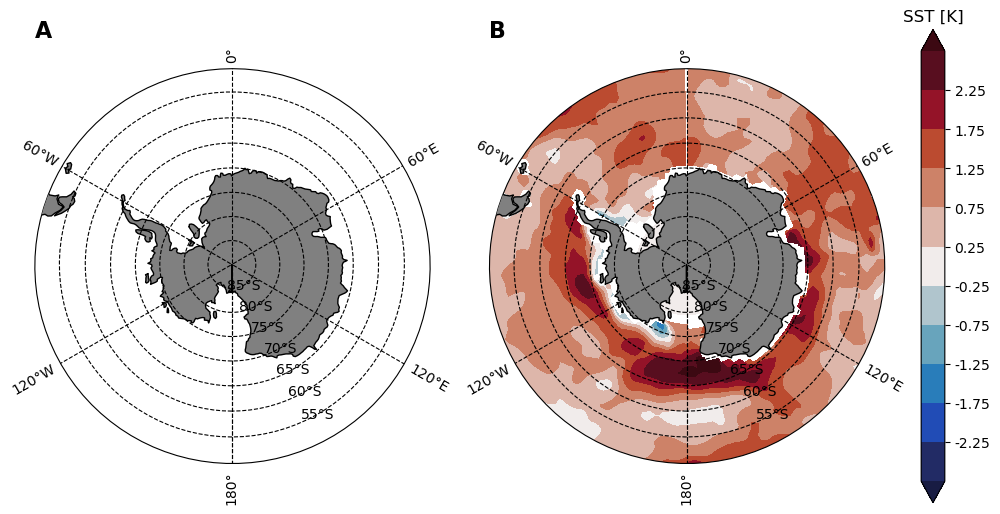

In [8]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")

save_info = {
    "save": True,
    "path": "figures/Figure_SX_DEC_SSTs.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-2.75, 3.25, .5),
    "shared": True,
    "ticks": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
    "tick_labels": [-2.25, -1.75, -1.25, -.75, -.25, .25, .75, 1.25, 1.75, 2.25],
}

a = era5_atm_anoms["sst"].sel(time="2023-12", method="nearest").squeeze()
print(a)
print(era5_atm_anoms["sst"].time)
era5 = {
    "ds": era5_atm_anoms["sst"].sel(time="2023-12", method="nearest").squeeze(),
    "left_title": "A"
}
a = cesm2_sst_anoms["SST"].sel(time="2023-12").squeeze(),
print(a)
cesm2 = {
    "ds": cesm2_sst_anoms["SST"].sel(time=np.datetime64("2023-12")).squeeze(),
    "left_title": "B"
}

spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## Sea Ice Thickness

In [ ]:
##### BASE CASE WITH NUDGING ####
cesm2_ice_anoms = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
cesm2_ice = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-regrid.nc")
cesm2_ice_clim = xr.open_dataset("../data/cesm2_ice_monthly_1950-01_2023-12-clim.nc")
# cesm2_ice_clim = cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze()

##### ENSEMBLE FORECAST ####
# cesm2_ice_anoms = xr.open_dataset("../data/persistence_ensemble/1980/1980_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
# ens = []
# ens_mems = members = ["1980", "1989", "1994", "1998", "1999", "2005", "2007", "2014"]
# for mem in ens_mems: 
#     cesm2_ice_ens = xr.open_dataset(f"../data/persistence_ensemble/{mem}/{mem}_cesm2_ice_monthly_1950-01_2023-12-regrid.nc")["aice"]
#     ens.append(cesm2_ice_ens)
# aice_ens = xr.concat(ens, "year")
# aice_ens
nsidc_ice = xr.open_dataset("../data/nsidc_regrid.nc")
# nsidc_ice

In [ ]:
save_info = {
    "save": False,
    "path": "figures/tes.png",
    "dpi": 400,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r, cmocean.cm.balance_r],
    "units": ["SIT [m]", "SICONC [%]"],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1), np.arange(-1, 1.1, .1)]
}

cesm2_thickness = {
    "title": "CESM2 SIT (2023-JJA)",
    # "ds": cesm2_ice_anoms["sithick"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "ds": cesm2_ice["sithick"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_siconc = {
    "title": "TEST",
    # "ds": cesm2_ice_anoms["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "ds": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), #- aice_ens.mean("year").resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "edge": cesm2_ice["aice"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Orange - Nudged
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(), # Magenta - Climatology 
    # "edge_ens": aice_ens.mean("year").resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Blue - Free Ensemble
}

spatial_obs_plot(
    dfs={
        "cesm2_thickness":  cesm2_thickness, 
        "cesm2_siconc": cesm2_siconc,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

## ATM

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")
era5_atm_anoms
# cesm2_atm_anoms

### Windspeed

In [ ]:
save_info = {
    "save": True,
    "path": "figures/windspeed.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"Windspeed 10m [ms$^{-2}$]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    # ERA5 Wind Speed Anomalies JJA 2022
    "ds": era5_atm_anoms["si10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        100
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    # CESM2 Wind Speed Anomalies JJA 2022
    "ds": cesm2_atm_anoms["U10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        100,
    ]
}

diff = {
    "title": "ERA5 - CESM2", 
    "ds": era5["ds"] - cesm2["ds"],
    "winds": [
        era5["wind"][0] - cesm2["wind"][0],
        era5["wind"][1] - cesm2["wind"][1],
    ]
}

In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### MSLP 

In [ ]:
save_info = {
    "save": True,
    "path": "figures/mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["msl"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        75,
    ]
}


In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### SST

In [ ]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
cesm2_sst_anoms

In [ ]:
era5_atm_anoms

In [ ]:
save_info = {
    "save": True,
    "path": "figures/sst.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/sst_2023MAM.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-MAM",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-MAM",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-03").squeeze(),
}


In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/sst_2023DJF.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-DJF",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-DJF",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-12").squeeze(),
}


In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/sst_2022JJA.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"SST [K]",
    "levels": np.arange(-3, 3.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2022-JJA",
    "ds": era5_atm_anoms["sst"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2022-JJA",
    "ds": cesm2_sst_anoms["SST"].resample(time="QS-DEC").mean(dim="time").sel(time="2022-06").squeeze(),
}


In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Z500

In [ ]:
era5_atm_anoms_levels = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-pressure-anoms.nc")
# era5_atm_anoms_levels.sel(level=500)["z"]

# cesm2_atm_anoms["Z3"].isel(lev=2)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/z500.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"Z500 [$m$]",
    "levels": np.arange(-100, 110, 10),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms_levels.sel(level=500)["z"].sel(time="2023-08").squeeze() / 9.8,
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["Z3"].isel(lev=2).sel(time="2023-08").squeeze(),
}

In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### 2TM 

In [ ]:
cesm2_atm_anoms
era5_atm_anoms

In [ ]:
save_info = {
    "save": True,
    "path": "figures/t2m.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"T2M [K]",
    "levels": np.arange(-10, 11, 1),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["t2m"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}


In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5, 
        "cesm2": cesm2,
        # "diff": diff
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### Ice

In [ ]:
cesm2_ice_anoms

In [ ]:
cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() + cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze()

In [ ]:
save_info = {
    "save": True,
    "path": "figures/daidt.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": "PuOr",
    "units": r"$\frac{dA}{dt}$ [%]",
    "shared": True,
    "levels": np.arange(-1, 1.1, .1)
}

cesm2_thermo = {
    "title": r"$\frac{dA}{dt}_{thermo}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
}

cesm2_dynam = {
    "title": r"$\frac{dA}{dt}_{dynam}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        .75
    ]
}

cesm2_sum= {
    "title": r"$\frac{dA}{dt}$ (2023-JJA)",
    "ds": cesm2_ice_anoms["daidtd"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze() + cesm2_ice_anoms["daidtt"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
    "wind": [
        cesm2_ice_anoms["uvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Zonal
        cesm2_ice_anoms["vvel"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(), # Meridional
        .75
    ]
}

In [ ]:
spatial_obs_plot(
    dfs={
        "cesm2_sum": cesm2_sum,
        "cesm2_thermo":  cesm2_thermo, 
        "cesm2_dynam": cesm2_dynam,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

##  ENSO Composites

In [ ]:
cesm2_atm_anoms = xr.open_dataset("../data/cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
era5_atm_anoms = xr.open_dataset("../data/ERA5_monthly_1979-01_2023-12_full-single-anoms.nc")


In [ ]:
# Load Nino3.4 index
def read_csv(ds, fp, len_header): 
    index = []
    with open(fp, newline='') as csvfile:
        csvf = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for i, row in enumerate(csvf):
            if i < len_header: continue
            if i == len_header: 
                header = row[0].split(',')
                continue
                
            ds[i-(len_header+1), :] = row[0].split(',')[1:]
            index.append(row[0].split(',')[0])
    
    ds = pd.DataFrame(data=ds, index=np.array(index), columns=header[1:])
    return ds
        
    
    
def read_txt(ds, fp, len_header, fill=-99.99):
    """
    Read arbitrary text file with header and data delineated with a space
    """
    nyrs, nmons = ds.shape
    years = []
    
    with open(fp) as f:
        lines = f.readlines()
        for n, line in enumerate(lines):
            if n < len_header: continue # skip header
            if n >= (nyrs+len_header): break # skip footer
            
            cidx = line.split()
            years.append(int(cidx[0]))
            ds[n-len_header, :] = cidx[1:]
            
    ds = xr.DataArray(
        data=ds,
        dims=["year", "month"],
        coords=dict(year=years, month=np.arange(1, 1+nmons))
    )
    ds = ds.where(ds != fill, np.nan)

    return ds

def load_nino34():
    nmonths = 12
    nino34 = read_txt(np.zeros((2024 - 1948, nmonths)), os.path.join("/glade/work/zespinosa/data/index/", "ENSO/Nino34_194801-202309_anoms.txt"), len_header=2)
    nino34 = nino34.stack(time=("year", "month"))
    nino34["time"] = np.arange("1948-01", "2024-01", dtype="datetime64[M]")
    # Select time overlapping with atmospheric data (1980 - 2020)
    nino34 = nino34.to_dataset(name="nino34")

    return nino34

nino34 = load_nino34()
nino34JJA = nino34.sel(time=slice("1980-01", "2023-09")).resample(time=SEASON).mean(dim="time")["nino34"][2::4]

In [ ]:
nino34.sel(time=slice("1980-01", "2023-09-01"))

In [ ]:
def time_series_plot(ts):
    colors = ['#ef8a62', '#67a9cf']
    time = ts.time

    ts = ts/ts.std("time")

    time_pos = time[ts > 0]
    ts_pos = ts[ts > 0]

    time_neg = time[ts <= 0]

    ts_pos = np.where(ts > 0, ts, 0)
    ts_neg = np.where(ts <= 0 , ts, 0)

    plt.fill_between(x=time, y1=0, y2=ts_pos, color=colors[0])
    plt.fill_between(x=time, y1=ts_neg, y2=0, color=colors[1])
    plt.hlines([0], time[0], time[-1], color="black")
    plt.grid()
    plt.ylabel(r"Nino3.4 STD Anomaly", fontsize=16)
    plt.fill_between(["2023-01-01", "2023-09-01"], -3, 3, color='gray', alpha=0.5)
    fig = plt.gcf()
    fig.set_size_inches(14, 6)
    plt.savefig("figures/nino34.png", dpi=1200, bbox_inches="tight")

time_series_plot(ts=nino34["nino34"].sel(time=slice("1980-01", "2023-09-01")))

In [ ]:
def nino_composite(nino34, cesm2):
    pos_enso = xr.where(nino34 > nino34.std("time"), cesm2, np.nan)
    neg_enso = xr.where(nino34 < -nino34.std("time"), cesm2, np.nan)

    pos_enso = pos_enso.mean(dim="time", skipna=True)
    neg_enso = neg_enso.mean(dim="time", skipna=True)

    return pos_enso, neg_enso, pos_enso - neg_enso

In [ ]:
cesm2_ice_anoms_JJA = cesm2_ice_anoms["aice"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
pos_enso_ice, neg_enso_ice, diff_enso_ice = nino_composite(nino34JJA, cesm2_ice_anoms_JJA)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_composites.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance_r,
    "units": "SICONC [%]",
    "shared": True,
    "levels": np.arange(-.5, .55, .05),
}

cesm2_pos = {
    "title": "CESM2 El Nino",
    "ds": pos_enso_ice,
    "edge": pos_enso_ice,
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}

cesm2_neg = {
    "title": "CESM2 La Nina",
    "ds": neg_enso_ice,
    "edge": neg_enso_ice,
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}


cesm2_diff = {
    "title": "CESM2 Nino-Nina",
    "ds": diff_enso_ice,
}

spatial_obs_plot(
    dfs={
        "cesm2_pos": cesm2_pos,
        "cesm2_neg": cesm2_neg,
        "cesm2_diff":  cesm2_diff, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO MSLP ERA5

In [ ]:
era5_atm_anoms_MSLP = era5_atm_anoms["msl"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
era5_atm_anoms_u10 = era5_atm_anoms["u10"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]
era5_atm_anoms_v10 = era5_atm_anoms["v10"].sel(time=slice("1980-01", "2023-08")).resample(time="QS-DEC").mean(dim="time")[2::4]

pos_enso_mslp, neg_enso_mslp, diff_enso_mslp = nino_composite(nino34JJA, era5_atm_anoms_MSLP)
pos_enso_u10, neg_enso_u10, diff_enso_u10 = nino_composite(nino34JJA, era5_atm_anoms_u10)
pos_enso_v10, neg_enso_v10, diff_enso_v10 = nino_composite(nino34JJA, era5_atm_anoms_v10)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/era5_enso_composites_mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

pos_enso = {
    "title": "ERA5 El Nino",
    "ds": pos_enso_mslp/100,
    "wind": [
        pos_enso_u10, # Zonal
        pos_enso_v10, # Meridional
        40
    ]
}
neg_enso = {
    "title": "ERA5 La Nina",
    "ds": neg_enso_mslp/100,
    "wind": [
        neg_enso_u10, # Zonal
        neg_enso_v10, # Meridional
        40
    ]
}

diff_enso = {
    "title": "ERA5 Nino-Nina",
    "ds": diff_enso_mslp/100,
    "wind": [
        diff_enso_u10, # Zonal
        diff_enso_v10, # Meridional
        40
    ]
}

spatial_obs_plot(
    dfs={
        "cesm2_pos": pos_enso,
        "cesm2_neg": neg_enso,
        "cesm2_diff":  diff_enso, 
    }, 
    cmap_info=cmap_info,
    save_info=save_info, 
)

### ENSO MSLP CESM2

In [ ]:
cesm2_atm_anoms_MSLP = cesm2_atm_anoms["PSL"].sel(time=slice("1980-01", "2023-09")).resample(time=SEASON).mean(dim="time")[2::4]
cesm2_atm_anoms_u10 = cesm2_atm_anoms["U"].isel(lev=0).sel(time=slice("1980-01", "2023-09")).resample(time=SEASON).mean(dim="time")[2::4]
cesm2_atm_anoms_v10 = cesm2_atm_anoms["V"].isel(lev=0).sel(time=slice("1980-01", "2023-09")).resample(time=SEASON).mean(dim="time")[2::4]

pos_enso_mslp, neg_enso_mslp, diff_enso_mslp = nino_composite(nino34JJA, cesm2_atm_anoms_MSLP)
pos_enso_u10, neg_enso_u10, diff_enso_u10 = nino_composite(nino34JJA, cesm2_atm_anoms_u10)
pos_enso_v10, neg_enso_v10, diff_enso_v10 = nino_composite(nino34JJA, cesm2_atm_anoms_v10)


In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_composites_mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 13, 1),
    "shared": True
}

pos_enso = {
    "title": "CESM El Nino",
    "ds": pos_enso_mslp/100,
    "wind": [
        pos_enso_u10, # Zonal
        pos_enso_v10, # Meridional
        40
    ]
}

neg_enso = {
    "title": "CESM La Nina",
    "ds": neg_enso_mslp/100,
    "wind": [
        neg_enso_u10, # Zonal
        neg_enso_v10, # Meridional
        40
    ]
}

diff_enso = {
    "title": "CESM Nino-Nina",
    "ds": diff_enso_mslp/100,
    "wind": [
        diff_enso_u10, # Zonal
        diff_enso_v10, # Meridional
        40
    ]
}

In [ ]:
spatial_obs_plot(
    dfs={
        "cesm2_pos": pos_enso,
        "cesm2_neg": neg_enso,
        "cesm2_diff":  diff_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO SST Composites

In [ ]:
cesm2_sst_anoms = xr.open_dataset("../data/cesm2_ocn-sst_monthly_1950-01_2023-12-anoms.nc")
cesm2_sst_anoms_comp = cesm2_sst_anoms["SST"].sel(time=slice("1980-01", "2023-09")).resample(time=SEASON).mean(dim="time")[2::4]
pos_enso_sst, neg_enso_sst, diff_enso_sst = nino_composite(nino34JJA, cesm2_sst_anoms_comp)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_composites_sst.png",
    "dpi": 600,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": "SST [K]",
    "shared": True,
    "levels": np.arange(-1., 1.1, .1),
}

cesm2_pos = {
    "left_title": "CESM2 El Nino",
    "ds": pos_enso_sst,
}

cesm2_neg = {
    "left_title": "CESM2 La Nina",
    "ds": neg_enso_sst,
}


cesm2_diff = {
    "left_title": "CESM2 Nino-Nina",
    "ds": diff_enso_sst,
}

spatial_obs_plot(
    dfs={
        "cesm2_pos": cesm2_pos,
        "cesm2_neg": cesm2_neg,
        "cesm2_diff":  cesm2_diff, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO ATM

In [ ]:
enso_cesm2_atm_anoms = xr.open_dataset("../data/enso_cesm2_atm_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_atm_anoms

In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_t2m.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance, cmocean.cm.balance],
    "units": [r"T2M [K]", r"T2M [K]"],
    "levels": [np.arange(-10, 10.5, .5), np.arange(-5, 5.2, .2)],
    "shared": False
}

# era5 = {
#     "title": "ERA5 2023-JJA",
#     "ds": era5_atm_anoms["t2m"].resample(time="QS-DEC").mean(dim="time").sel(time="2023-06").squeeze(),
# }

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}

cesm2_enso = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["T"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["T"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
}


In [ ]:
spatial_obs_plot(
    dfs={
        "cesm2": cesm2,
        "cesm2_enso":  cesm2_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_mslp.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": cmocean.cm.balance,
    "units": r"MSLP [hPa]",
    "levels": np.arange(-12, 12.5, .5),
    "shared": True
}

era5 = {
    "title": "ERA5 2023-JJA",
    "ds": era5_atm_anoms["msl"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        era5_atm_anoms["u10"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        era5_atm_anoms["v10"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75
    ]
}

cesm2 = {
    "title": "CESM2 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        75,
    ]
}

cesm2_enso = {
    "title": "CESM2 (ENSO Removed) 2023-JJA",
    "ds": cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100 - enso_cesm2_atm_anoms["PSL"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze()/100,
    "wind": [
        cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["U"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Zonal
        cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_atm_anoms["V"].isel(lev=0).resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(), # Meridional
        30,
    ]
}

In [ ]:
spatial_obs_plot(
    dfs={
        "era5": era5,
        "cesm2": cesm2,
        "cesm2_enso":  cesm2_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_mslp_noshared.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance, cmocean.cm.balance],
    "units": [r"MSLP [hPa]", r"MSLP [hPa]"],
    "shared": False,
    "levels": [np.arange(-15, 16, 1), np.arange(-6, 6.5, .5)]
}
spatial_obs_plot(
    dfs={
        "cesm2": cesm2,
        "cesm2_enso":  cesm2_enso, 
    }, 
    cmap_info=cmap_info, 
    save_info=save_info, 
)

### ENSO Ice

In [ ]:
enso_cesm2_ice_anoms = xr.open_dataset("../data/enso_cesm2_ice_monthly_1950-01_2023-12-anoms.nc")
enso_cesm2_ice_anoms

In [ ]:
save_info = {
    "save": True,
    "path": "figures/enso_siconc.png",
    "dpi": 1200,
}

cmap_info = {
    "cmap": [cmocean.cm.balance_r, cmocean.cm.balance_r],
    "units": ["SICONC [%]", "SICONC [%]"],
    "shared": False,
    "levels": [np.arange(-1, 1.1, .1), np.arange(-.3, .31, .01)]
}

cesm2_siconc = {
    "title": "CESM2 SICONC 2023-JJA",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge_clim": cesm2_ice_clim["aice"].resample(time="QS-DEC").mean(dim="time").isel(time=2).squeeze(),
}

cesm2_siconc_noenso = {
    "title": "CESM2 SICONC (NO ENSO) 2023-JJA",
    "ds": cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze() - enso_cesm2_ice_anoms["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge": cesm2_ice["aice"].resample(time=SEASON).mean(dim="time").sel(time=SEASON_TIME).squeeze(),
    "edge_clim": cesm2_ice_clim["aice"].resample(time=SEASON).mean(dim="time").isel(time=2).squeeze(),
}

spatial_obs_plot(
    dfs={
        "cesm2_siconc":  cesm2_siconc, 
        "cesm2_siconc_noenso": cesm2_siconc_noenso,
    }, 
    cmap_info=cmap_info, 
    save_info=save_info,
)